In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39751,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:46215,Total threads: 2
Dashboard: /proxy/39049/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:36667,


In [16]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
     
def IOBM(DS):
    return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 100)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = ssta(DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO-SETIO).drop('month')
def eio(DS):
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (SETIO).drop('month')
def eio_1(DS):
    SETIO = (DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (SETIO)
def wio(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    return (WTIO).drop('month')
def wio_1(DS):
    WTIO = (DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    return (WTIO)

In [4]:
def IOD_events(ds):
    #get the DMI timeseries in seaaons starting D(0)JF(1) etc
    QS = dmi(ds).resample(time='QS-DEC').mean(dim="time")
    #select SON seasons into a timeseries
    SON = QS.groupby('time.season')["SON"]
    #now use this to select all events and create da's of niod and piod event values
    lower,upper = SON.quantile([0.25, 0.75])
    nIOD = SON.where(SON <= lower.values).dropna(dim = "time")
    pIOD = SON.where(SON > upper.values).dropna(dim = "time")
    return nIOD, pIOD
def get_IOD_times(ds_sst, ds_var):
    nIOD, pIOD = IOD_events(ds_sst)
    #now get the times where the variable is in SON
    SON_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"]
    #Now use nIOd and PIOD to get the times that we want
    nIOD_var = SON_var.where(SON_var.time == nIOD.time).dropna(dim = "time")
    pIOD_var = SON_var.where(SON_var.time == pIOD.time).dropna(dim = "time")
    return nIOD_var, pIOD_var

In [5]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
VC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
MC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})


In [8]:
VC = VC.sst
VC = VC.compute()

In [9]:
MC = MC.sst
MC = MC.compute()

In [10]:
OC = OC.sst
OC = OC.compute()

In [12]:
ctrl = ctrl_sst.sst
ctrl = ctrl.compute()

In [14]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360# - 180
    df = df.sortby(df.xt_ocean)
    return df

In [15]:
ctrl = roll_lon(ctrl)

In [48]:
VC = roll_lon(VC)
OC = roll_lon(OC)
MC = roll_lon(MC)

In [49]:
def composite_iod_yrs(DS):
    DMI = dmi(DS) # calculate DMI
    TH = DMI.groupby("time.season")['SON'].std() # get threhold of 1 std dev
    DMI_gp_yr = DMI.groupby('time.year') # group by year
    pos_years = []
    neg_years = []
    for year in DMI_gp_yr.groups: # go through each year and if abs(SON DMI) is > 1 std dev append to pos or negative IOD events
        #get the SON average form that year
        SON = DMI_gp_yr[year].groupby('time.season')['SON'].mean("time")
        if SON > TH:
            pos_years.append(DMI_gp_yr[year])
        if SON < -TH:
            neg_years.append(DMI_gp_yr[year])
    #create timeseries for pos and neg events
    pos_IOD = xr.concat(pos_years, dim = "time")
    neg_IOD = xr.concat(neg_years, dim = "time")
    return pos_IOD, neg_IOD

In [50]:
Vpiod, Vniod = composite_iod_yrs(VC)
Opiod, Oniod = composite_iod_yrs(OC)
Mpiod, Mniod = composite_iod_yrs(MC)
Cpiod, Cniod = composite_iod_yrs(ctrl)

In [57]:
Vniod

<xarray.DataArray 'sst' (time: 132)>
array([ 0.15483782, -0.53175974, -0.30917475,  0.04178548, -0.4364823 ,
       -0.5194974 , -0.7406608 , -1.2587622 , -1.3569437 , -1.3921442 ,
       -1.0741498 , -0.72998226,  0.41266018,  0.2983847 ,  0.00877565,
        0.41040608,  0.03728292, -0.05044705, -0.35313085, -0.54690826,
       -0.6726735 , -0.6715673 , -0.6805712 , -0.5458275 , -0.12146816,
        0.08282524,  0.16071731,  0.4253292 , -0.10111611, -0.44916397,
       -0.7661884 , -0.8212168 , -0.88066196, -0.8819474 , -0.4164663 ,
       -0.3520155 , -0.35864112, -0.3670115 , -0.18163715, -0.02366187,
       -0.06078048, -0.22037888,  0.04744726, -0.26587704, -0.59388196,
       -0.6496115 , -0.60915244, -0.5032003 , -0.53198457, -0.03882471,
       -0.18876496,  0.11987001, -0.02512631, -0.22967583, -0.5856814 ,
       -0.8483746 , -0.9831978 , -0.782913  , -0.6432052 , -0.81100833,
       -0.53433037, -0.3321898 , -0.1334843 ,  0.14267333, -0.4167372 ,
       -0.70718867, -0.7281386 , -0.69054675, -1.010721  , -0.9278506 ,
       -0.69047594, -0.43906772,  0.16353819,  0.21342427, -0.2888153 ,
       -0.44280756, -0.5031554 , -0.3701089 , -0.41920638, -0.6286484 ,
       -0.70718104, -0.54611164, -0.5373106 , -0.3854924 ,  0.39123487,
        0.13580357, -0.12285212,  0.3080228 ,  0.24060681,  0.30155838,
       -0.3199767 , -0.69999474, -0.9387678 , -0.807652  , -0.60921663,
       -0.6741742 , -0.12659511, -0.121096  , -0.04443333, -0.44043857,
       -0.05532511,  0.15977545, -0.17955795, -0.5310661 , -0.68453246,
       -0.56544167, -0.47594196, -0.36854213, -0.01941288,  0.08204422,
        0.5956998 ,  0.62479055, -0.11865465, -0.3096676 , -0.45495182,
       -0.8726331 , -0.92807925, -0.8088614 , -0.70720065, -0.70597374,
        0.5083868 ,  0.41361037,  0.28831208,  0.23430629,  0.25287926,
       -0.268031  , -0.90907323, -1.0445733 , -0.8693546 , -0.9696251 ,
       -0.8574695 , -0.82465166], dtype=float32)
Coordinates:
  * time     (time) object 0952-01-16 12:00:00 ... 1011-12-15 12:00:00

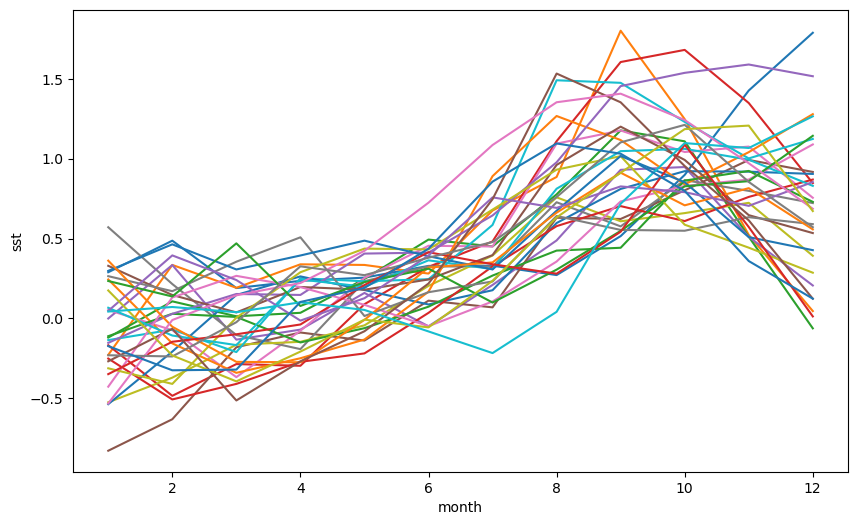

In [66]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
for year, group in Cpiod.groupby("time.year"):
    group.groupby("time.month").mean("time").plot(label=str(year))

In [58]:
Cpiod.groupby("time.month").plot()

AttributeError: 'DataArrayGroupBy' object has no attribute 'plot'

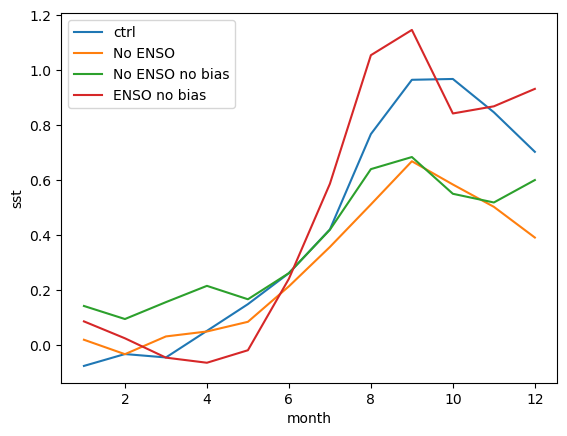

In [53]:
Cpiod.groupby("time.month").mean("time").plot(label = "ctrl")
Mpiod.groupby("time.month").mean("time").plot(label = "No ENSO")
Opiod.groupby("time.month").mean("time").plot(label = "No ENSO no bias")
Vpiod.groupby("time.month").mean("time").plot(label = "ENSO no bias")
plt.legend()

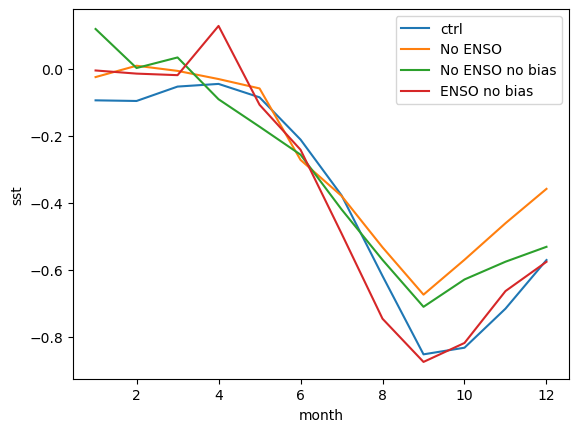

In [54]:
Cniod.groupby("time.month").mean("time").plot(label = "ctrl")
Mniod.groupby("time.month").mean("time").plot(label = "No ENSO")
Oniod.groupby("time.month").mean("time").plot(label = "No ENSO no bias")
Vniod.groupby("time.month").mean("time").plot(label = "ENSO no bias")
plt.legend()

In [17]:
DMI = dmi(ctrl)

In [28]:
TH = DMI.groupby("time.season")['SON'].std()

In [32]:
DMI_gp_yr = DMI.groupby('time.year')

In [41]:
DMI_gp_yr[1002].groupby('time.season')['SON'].mean("time")

<xarray.DataArray 'sst' ()>
array(0.3608642, dtype=float32)

In [42]:
pos_years = []
neg_years = []
for year in DMI_gp_yr.groups:
    #get the SON average form that year
    SON = DMI_gp_yr[year].groupby('time.season')['SON'].mean("time")
    if SON > TH:
        pos_years.append(DMI_gp_yr[year])
    if SON < -TH:
        neg_years.append(DMI_gp_yr[year])

In [44]:
pos_IOD = xr.concat(pos_years, dim = "time")

In [45]:
neg_IOD = xr.concat(neg_years, dim = "time")

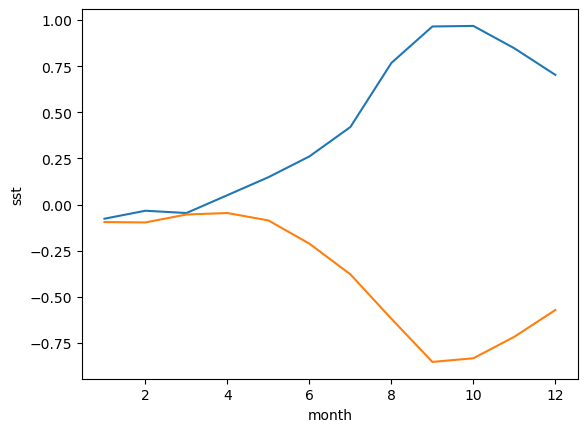

In [47]:
pos_IOD.groupby("time.month").mean("time").plot()
neg_IOD.groupby("time.month").mean("time").plot()
